In [1]:
###########
# IMPORTS #
##########

import warnings
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict


# MNE functions
import mne
from mne import Epochs, find_events
from mne.decoding import Vectorizer
from mne.preprocessing import ICA, create_ecg_epochs, create_eog_epochs
from mne.time_frequency import psd_welch

# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

warnings.filterwarnings('ignore')

In [3]:
#################################
## LOADING AND PREPARING DATA ##
###############################

# loading dataset
raw = mne.io.read_raw_eeglab("data/Fred_Labo_oddball.set", preload=True)

# Getting channel names
ch_names = raw.ch_names

# Removing Right auxiliary channel
raw.drop_channels(['Right AUX']) 

# Mastoid re-referencing
raw.set_eeg_reference(ref_channels=['TP9', 'TP10'])


Reading /home/hororo/gitrepos/isae_ICM_cours/data/Fred_Labo_oddball.fdt
Reading 0 ... 310907  =      0.000 ...  1214.480 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawEEGLAB | Fred_Labo_oddball.fdt, 4 x 310908 (1214.5 s), ~9.5 MB, data loaded>

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (33.004 sec)

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


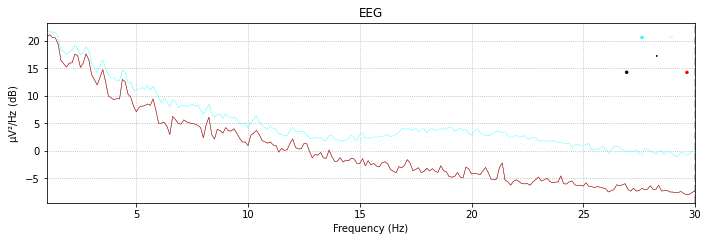

In [4]:
#####################
# FILTERING DATA   ##
#####################

raw.filter(0.1, 30, method='fir')

mne.viz.plot_raw_psd(raw, fmin=1, fmax=30)

plt.show()

In [6]:
###################
# EPOCHING DATA  ##
###################

custom_mapping = {'10': 1, '20': 2}


events, event_dict = mne.events_from_annotations(raw, event_id=custom_mapping)
epochs = Epochs(raw, events=events, event_id=custom_mapping,
                tmin=-0.1, tmax=0.8, baseline=(-0.1,0),                                                                                  
                reject={'eeg': 100e-6}, preload=True,                                                                                  
                verbose=False, picks=['AF7','AF8','TP9','TP10'], event_repeated='drop')

print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

epochs

Used Annotations descriptions: ['10', '20']
sample drop %:  12.749999999999995


Number of events,349
Events,10: 8920: 260
Time range,-0.102 – 0.801 sec
Baseline,-0.100 – 0.000 sec


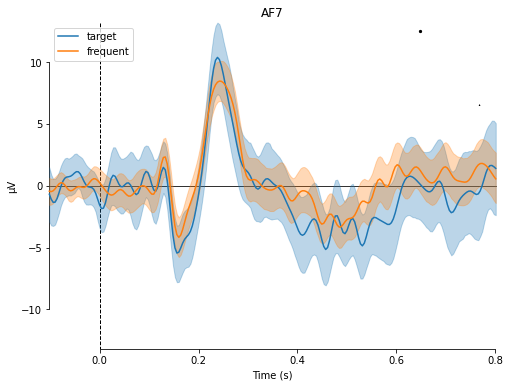

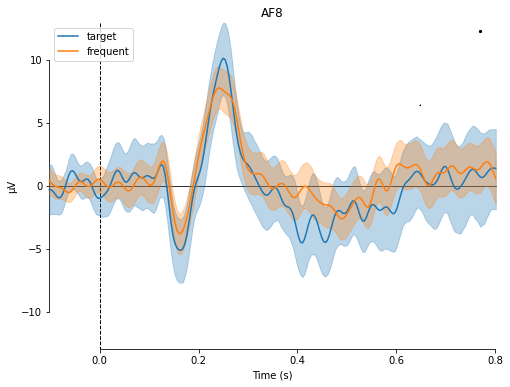

[<Figure size 576x432 with 2 Axes>]

In [7]:
########################
## PLOTTING ERPs #######
########################



evokeds = dict(target=list(epochs['10'].iter_evoked()),
               frequent=list(epochs['20'].iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds, picks='AF7')
mne.viz.plot_compare_evokeds(evokeds, picks='AF8')


In [8]:
######################################
# CLASSIFICATION TARGET vs FREQUENT ##
#     From EEG Notebook             ##
######################################

clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))

clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())


# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))

results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

/home/hororo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hororo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

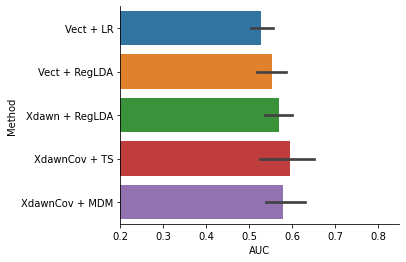

In [9]:
####################################
# PLOTTING CLASSIFICATION RESULTS #
###################################

plt.figure(figsize=[5,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()
plt.show()